In [1]:
%run ../Config/ImgConfig.ipynb
HTML("""<style>.jp-OutputArea-output {display: table-cell;text-align: center !important;vertical-align: middle !important;}.jp-OutputArea-output img {width: 70% !important;}</style>""")

# 6. Anomaly Detection

[index](../Index.ipynb) | [prev](./05.Forecasting.ipynb) | [next](./07.Conclusions.ipynb)

**Motivation**:

While initially the goal for this system was set around Object Detection, and then Forecasting, these two concepts were followed by another idea: Can object detections be used to detect anomalies and trigger useful alerts to the users?

This Chapter is an analysis of two methods for detecting anomalies, which I have identified as the most useful:

- based on unusually high count of objects in a given hour
- based on the content of the frames, which look very different to others

## 6.1. Anomalies estimated from event counts

Flagging object detections as anomalies can be determined by unusually high number of events in a given hour for an object class (like Person, Car, Cat, etc.).

This kind of anomaly detection routine could be run in real time when objects of a specific class are detected in the video stream. System compares a number of already registered objects in an hour versus a threshold (for example 3 vs 9) to determine if the next object should be classified as anomalous. If that limit is breached, a notification could be triggered to home owner.

These min and max thresholds could be also displayed in the forecast as two bars: one on left and one on the right hand side of the counts to make the alerts easily explainable.

This task forms a univariate outlier detection problem, where system learns the thresholds from the historical counts.

This section is focused around three individual ways of solving this problem:

- IQR (and improved version of IQR)
- Z-Score
- Probabilistic method

**Note:** Results and plots in this section is based on the *Person* object, but the same method can be applied to any object class.

Below is the count distribution for *Person*:

<p style="text-align: center; margin-bottom: 0;">Fig. 6.1. Count distribution - all hours</p>

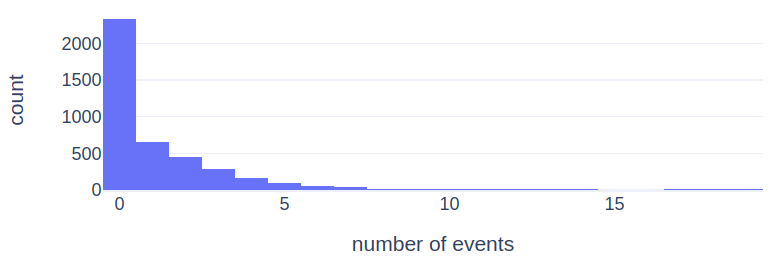

In [3]:
Image("../Resources/img/person-count-dist.png")

Overall this data is heavily skewed towards 0's, but this is expected. During the night or when it is dark, the number of objects is $0$, as the camera does not have the night-vision capability. In other time intervals there is just little activity taking place.

The mean $\mu$ of this population is $1.16$ and standard deviation $\sigma$ is $1.95$. Taking a square root of $\sigma$ gives $1.08$, which is close to $\mu$ and it is one of the main characteristics of the *Poisson distribution*.

Next, looking at the distribution of $\mu$'s for each hour shows a more detailed picture, where bars represent mean averages and red dots are a square root of $\sigma$.

<p style="text-align: center; margin-bottom: 0;">Fig. 6.2. Count distribution by hour</p>


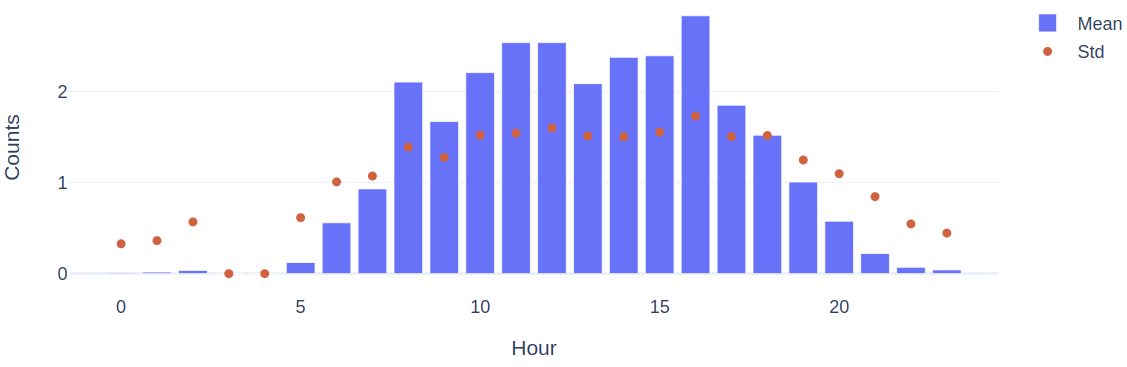

In [4]:
Image("../Resources/img/count-dist-by-hour.png")

This picture shows quite a large spread of means by hour, and it is sufficiently convincing to focus on anomaly detection for individual hours separately.

Looking at the frequency of counts for 4PM shows quite heavy skewness towards the left side:

<p style="text-align: center; margin-bottom: 0;">Fig. 6.3. Count distribution at 4PM</p>

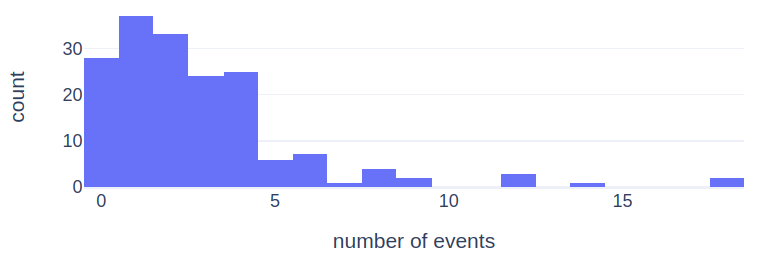

In [5]:
Image("../Resources/img/person-count-dist-singlehour.png")

**Note:** All code snippets, more in-depth commentary and code for plots created in this section can be found in the corresponding [Extra Notebook 6](../Notebooks/Extra.06.Person-AnomalyDetectionForHourlyCounts.ipynb).

### 6.1.1. IQR

There are many statistical tools to deal with this kind of problem, but arguably the most popular and easy to understand is IQR (Interquartile Range).

This method is used in a very popular plotting technique for outlier identification, the boxplot <cite data-cite="tukey:1977:analysis">(Tukey, 1977)</cite>. It is simple to explain, well understood and very often produces satisfactory results.

First, one would calculate an *Interquartile Range (IQR)* using the difference between the third and first quartile, where first ($Q1$) and third quartiles ($Q3$) are the medians of lower and upper halves of the data respectively:

$$IQR=Q3-Q1$$

Then the lower and upper bounds are calculated by subtracting and adding $IQR*1.5$ from $Q1$ and $Q3$ respectively:

$$lowerBound=Q1-(IQR*1.5)$$

$$upperBound=Q3+(IQR*1.5)$$

And finally, values below lower or above upper bound are classified is outliers:

$$
f(x)=\begin{cases}
  anomaly, & \text{if $x<lowerBound$ or $x>upperBound$}\\
  not-anomaly, & \text{otherwise}
\end{cases}
$$

, where $x$ is a count of objects in a single hour.

Below is a boxplot for the count dataset by hour:

<p style="text-align: center; margin-bottom: 0;">Fig. 6.4. IQR analysis - boxplot</p>

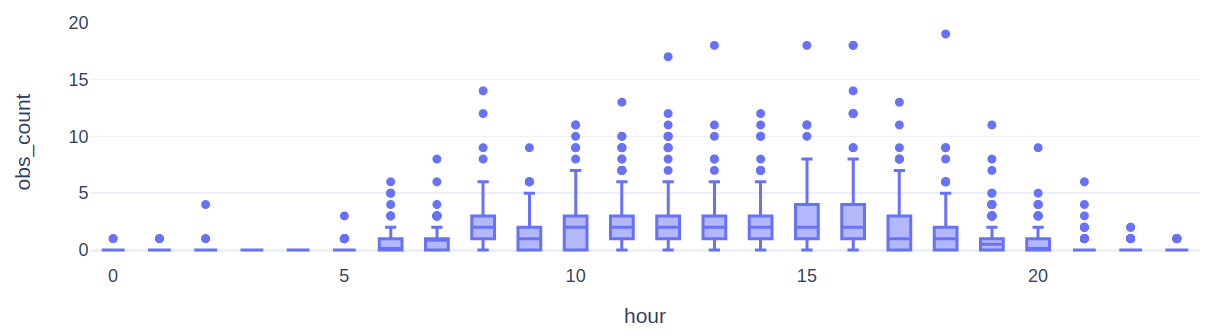

In [6]:
Image("../Resources/img/boxplot-by-hour.png")

Looking at the graph, it is flagging a lot of points. After calculating the percentage above and below the bounds, IQR method classifies $5\%$ of observations as anomalous.

The high percentage of anomalies is related to the fact that counts for each hour are heavily skewed, and as mentioned in the *Adjusted boxplot* <cite data-cite="hubert:2008:boxplot">(Hubert et al., 2008)</cite>, boxplots suffer from False Positives in heavily skewed datasets.

### 6.1.2. Adjusted boxplot for skewed distributions

In Hubert's research, an alternative method has been proposed to IQR: *An Adjusted Boxplot for Skewed
Distributions*.

The procedure is quite similar to IQR, but introduces additional steps:

- calculation of data skewness (called medcouple - MC):

$$MC = \frac{(Q3 − Q2) − (Q2 − Q1)}{Q3 − Q1}$$

For the count dataset and Person object class, this measure is $0.33$.

- Then, the lower and upper bounds are calculated as follows:

$$lowerBound=Q1-h_l(MC)IQR$$
$$upperBound=Q3+h_u(MC)IQR$$

, where:

$$h_l(MC)=1.5e^{aMC}$$
$$h_u(MC)=1.5e^{bMC}$$

The authors of the paper have optimized the values for the constants $a$ and $b$ as $-4$ and $3$, in a way that fences mark 0.7% observations as outliers.

Applying these calculations to the count dataset classifies $148$ observations as outliers, which represents $3.5\%$ of the dataset and still generates too many False Positives.

### 6.1.2. Z-Score

Z-Score determines how many standard deviations $\sigma%$ are points $X$ away from the mean $\mu$.

$$zScore_i=(x_i-\mu)\div\sigma$$

, where $x_i$ is the i-th data point, $\mu$ and $\sigma$ are a sample arithmetic mean and standard deviation respectively.

Z-Score has quite interesting properties when applied to Normal distributions, where $99.7\%$ of the data points lie between +/- 3 $\sigma$'s.

In case if the skewed count dataset it also performs quite well and identifies $75$ outliers, which represents $2\%$ of the dataset, but this is not always the case for skewed datasets.

### 6.1.3. Probabilistic method

Probabilistic models utilize *Bayesian Theorem* to derive the following formula from the Conditional Probability theory:

$$P(A|B)=\frac{P(B|A)P(A)}{P(B)}$$

Where:

- $P(A|B)$ is the posterior, meaning conditional probability of event $A$ given that $B$ is true
- $P(B|A)$ is the likelihood, also conditional probability of event $B$ occurring given $A$ is true
- $P(A)$ is the prior (information we already know about the data)
- $P(B)$ is the marginal probability of observing event $B$

There are many benefits from using probabilistic modeling. Some of them are included below:

- no assumptions made about the distribution of the data
- it allows to provide prior information to the model about distributions
- it does not require a lot of data
- it can generate predictions with the uncertainty about them

**Prior**

Probabilistic programming uses prior information already known (like a distribution of an outcome random variable), then it explicitly calls out the likelihood, which defines how to sample the probability space given the data, and then it performs an analysis of the posterior, which contains N-samples drawn from the distribution.

In relation to the count dataset, I have identified a $2$ candidate distributions, which can be used as a prior in the model:

- Half Student T distribution with parameters $\sigma=1.0$ and $\nu=1.0$ and density function:

$$f(t)=\frac{\gamma(\frac{\nu + 1}{2})}{\sqrt{\nu \pi} \Gamma (\frac{\nu}{2})} (1 + \frac{t^2}{\nu})^{-\frac{\nu + 1}{2}}$$

, where $\nu$ is the number of degrees of freedom and $\Gamma$ is the gamma function.

- Gamma distribution with parameters $\alpha=1.5$ (shape) and $\beta=0.5$ (rate) and density function:

$$f(x;\alpha;\beta)=\frac{\beta^\alpha x^{\alpha-1} e^{-\beta x}}{\Gamma(\alpha)}$$

, where $x>0$, $\alpha,\beta > 0$ and $\Gamma(\alpha)$ is the gamma function

Below is the multi-plot with both distributions and the true dataset with counts between 1PM and 3PM:

<p style="text-align: center; margin-bottom: 5px;">Fig. 6.5. Priors selection</p>

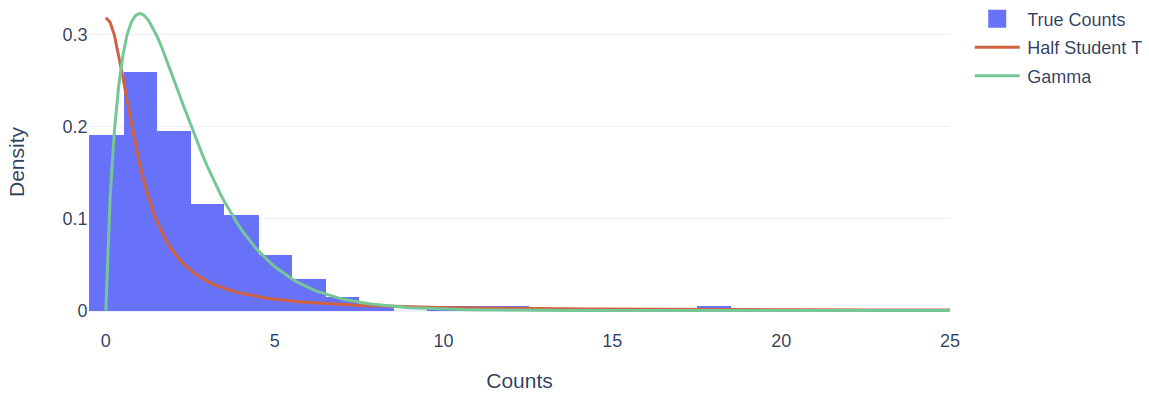

In [7]:
Image("../Resources/img/anomaly-det-priors.png")




Based on the graph above, Gamma distribution with $\alpha=1.8$ and $\beta=0.8$ seems to be more suitable to this distribution.

**Likelihood**

The next item needed is the likelihood function, which is used to estimate the counts for every hour, given the data $X$.

A suitable likelihood function in case of the count data is Poisson, which is given by:

$$L(\lambda;x_1,...,x_n)=\prod^{n}_{j=1}exp(-\lambda)\frac{1}{x_j!}\lambda^{x_j}$$

As highlighted in a STAT 504 course from Penn State <cite data-cite="stat:log">(Analysis of Discrete Data, n.d., l. 1.4)</cite>, likelihood is a tool for summarizing the data's evidence about unknown parameters, and often (due to computational convenience), it is transformed into log-likelihood.

The log-likelihood for the Poisson process is given by:

$$l(\lambda;x_1,...,x_n)=-n \lambda - \sum^n_{j=1}ln(x_j!)+ln(\lambda)\sum^n_{j=1}x_j$$

Now coding up the solution is made very simple with libraries for Probabilistic Programming, like `PyMC3`:

- first define a Gamma prior (it is possible to have a list of $24$ priors - one for each hour)
- then define a list Poisson likelihood functions (again, $1$ for each hour)
- finally, sample from the posterior and analyze results

Before going into the results, I would like to explain why sampling is used by PyMC3 and which sampling method is appropriate to which kind of data.

In order to compute the optimized values for the model's parameters (also called maximum a posteriori, or MAP), there are two paths to take:

- numerical optimization methods, which are usually fast and easy (`find_map` function in PyMC3)

Default optimization algorithm is BFGS <cite data-cite="fletcher:1987:optimization">(Fletcher et al., 1987)</cite>, but other functions from `scipy.optimize` are acceptable. The downside of this approach is that it often finds only local optima, and as advised in [PyMC3 documentation](https://docs.pymc.io/notebooks/getting_started.html), this method only exists for historical reasons. The second limitation is a lack of uncertainty measure, as only a single value for each parameter is returned.

- sampling based optimization used for more complex scenarios (`sample` function in PyMC3)

This method is a recommended, simulation-based approach with a few algorithms suitable for different problems:

- Binary variables will be assigned to BinaryMetropolis
- Discrete variables will be assigned to Metropolis
- Continuous variables will be assigned to NUTS (No-U-Turn Sampler)

The `sample` function return a `trace` object, which can be queried to obtain the samples for individual parameter. A standard deviation of these values can be interpreted as an uncertainty.

Sampling process for the count data dataset takes less than $30$ seconds.

Below are some of the most useful statistics (like mean, standard deviation, median and quantiles) for each hour, which can be easily generated by PyMC3 with the use of `pm.summary` method:

<p style="text-align: center; margin-bottom: 5px;">Fig. 6.6. PyMC3 - Posterior stats</p>

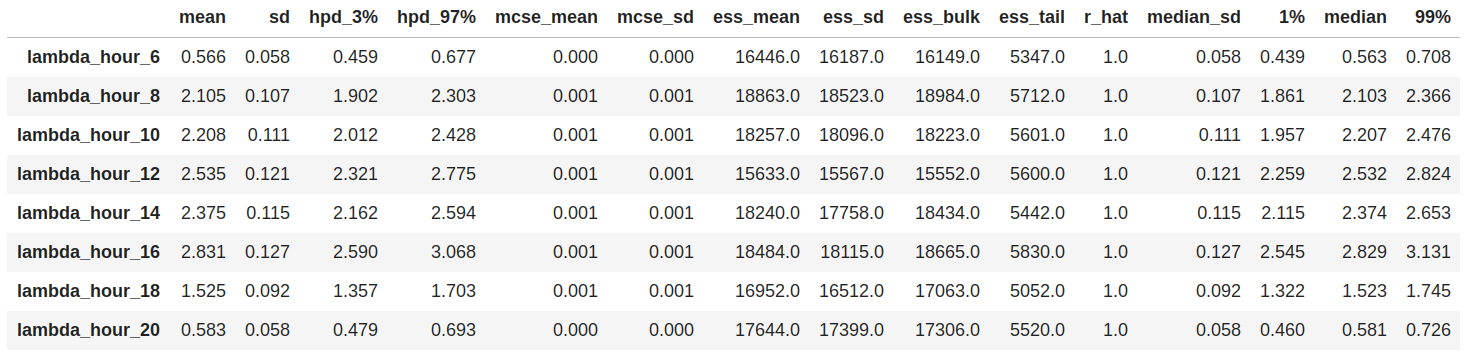

In [8]:
Image("../Resources/img/posterior_stats.png")

Next, one can take an advantage of having multiple samples for the estimated rate $\lambda$, and generate $N$ counts for all these rates (using all sampled rates for a single hour embeds the uncertainty into the generated counts).

Probability density for the 4PM then can be plotted and questions asked about the probability of obtaining a count $K$:

<p style="text-align: center; margin-bottom: 5px;">Fig. 6.7. Probability density for 4PM</p>

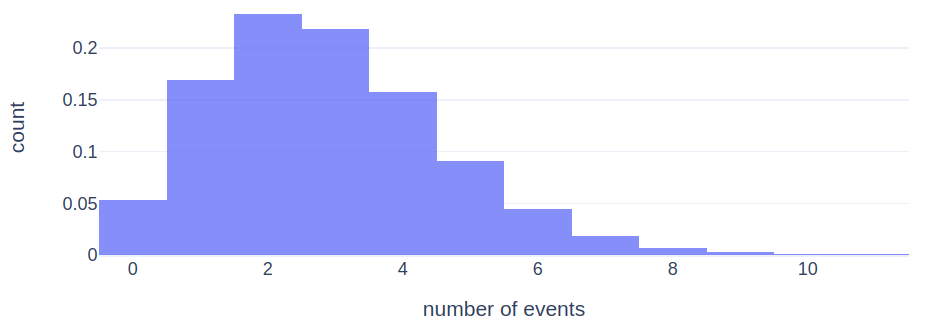

In [9]:
Image("../Resources/img/4pm-prob-dens.png")

For example, if $K=8$, then there is $1\%$ chance to see an $8$ or more objects at 4PM.

Now, the final idea here is to define a percentage of observations, which need to be classified as anomalies, and use the approach from above, but this time apply it to all hours.

Once this is set to $0.001$, $61$ anomalous observations are detected, which represents $1.5\%$ of the dataset. The result is the max count fence for each hour, above which counts become anomalies. For example the fence for 4PM has been determined as $9.0$.

To visualize the results for all hours I have generated a plot, with a dashed line representing the threshold for anomalies. Red dots are anomalies, and their size corresponds to their magnitude:

<p style="text-align: center; margin-bottom: 0;">Fig. 6.8. Anomaly thresholds by hour</p>

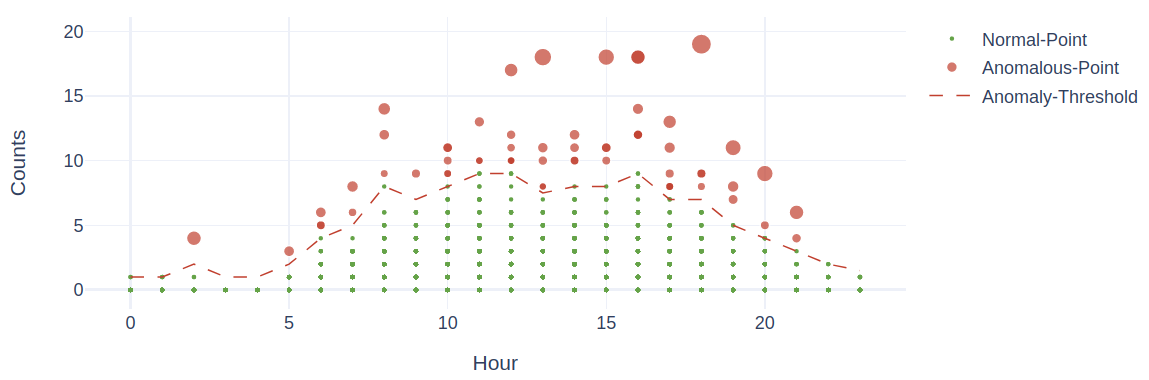

In [10]:
Image("../Resources/img/anomaly-thresholds.png")

### 6.1.4. Summary

Probabilistic Model is the most flexible and gives the most interesting opportunities based on the generated samples. The percentage of anomalies is fully under control, and can be made as strict, or as relaxed as required.

The next step in this section would be to actually embed the max-count fences in the hourly forecast graph, so it is clear for the users of the system when to expect an alert for each hour, and why an alert has been triggered.

It would be also interesting to calculate the fences using the rates estimated by Gaussian Process in the [Forecasting Chapter](05.Forecasting.ipynb#gp-rates). This way the fence would be tailored to the specific scenario (like weekend, rainy day, morning time for example).

## 6.2. Anomalies estimated from raw images' content

The aim of this section is to investigate if patterns encoded in raw images can identify anomalies.

Analysis below will be conducted with two goals in mind:
- There could be a process running in real time, which would tell the difference between the normal and unusual images, and based on that, it could send notifications to the users about suspicious activities
- On average, object detector identifies roughly $2000$ images each day. It is very tedious to scan through all of them every day. If there was a score, which could be used to sort images by the "most different ones", the manual process could be somewhat eliminated

In the *Deep Learning for Anomaly Detection: A Survey* paper <cite data-cite="chalapathy:2019:learning">(Chalapathy, 2019)</cite>, the author mentions that even though the fields of Anomaly Detection and Deep Learning have been well exploited by the researchers individually, these two areas are not linked enough and there are a lot of opportunities to explore.

Finding anomalies based on the camera frames can be framed as an *unsupervised Machine Learning* problem, where a model is trained to learn patterns encoded in the images through noisy reconstruction of the inputs. Then when a new (original) image is passed through this model, an error between the reconstructed and original image can be used to classify images as *normal* or *anomalous*.

Using unsupervised learning has been chosen mainly for two reasons:
- there are over $600K$ images collected in the process and they do not contain any anomaly-related labels
- anomaly detection usually deals with highly imbalanced datasets (where potentially less than $1\%$ represents anomalous images), but supervised models tend to prefer balanced datasets

The usage of *Deep Learning* is mostly motivated by the fact, that Deep Neural Networks can efficiently deal with large scale datasets (i.e. image data) and they can use GPU to significantly decrease parameter optimization time.

The Neural Network models, which learn how to reconstruct their own inputs are called *Auto Encoders*. Outside of anomaly detection, they are also used for data compression and noise removal.

I am using a Convolutional Auto Encoder in this section as CNNs are often selected for as complex datasets as image data (they have been previously used in [Chapter 4](04.DataCollection.ipynb) for Yolo object detections).

<p style="text-align: center; margin-bottom: 0;">Fig. 6.9. Auto-encoder diagram</p>

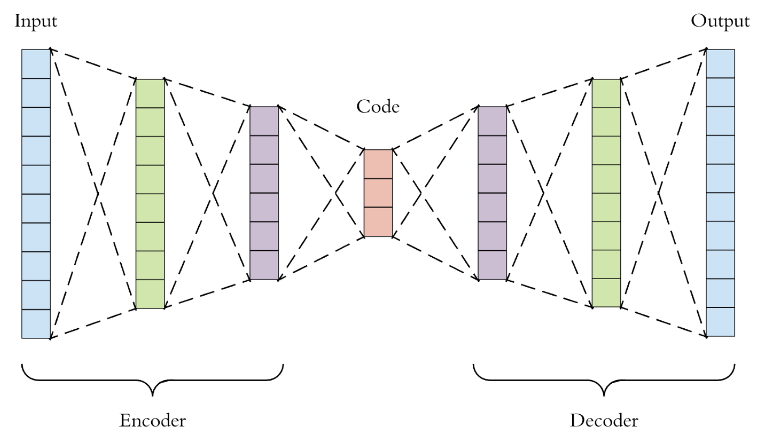

In [11]:
Image("../Resources/img/ae.png")

Please refer to the [Literature Review](./02.LiteratureReview.ipynb) chapter for more theoretical aspects around auto-encoders.

In contract to sections 6.1. above, auto encoders will use the data for all object classes combined, as there is no need to do it separately for different object classes.

**Note:** All code snippets, more in-depth commentary and code for plots created in this section can be found in the corresponding [Extra Notebook 7](../Notebooks/Extra.07.RawImagesAnomalyDetectionTraining.ipynb).

### 6.2.1. Computer Vision and image pre-processing

Starting point for this section are all object detections created in [Forecasting Chapter, Section 5.1.](./05.Forecasting.ipynb):

<p style="text-align: center; margin-bottom: 5px;">Fig. 6.10. Detections tabular data</p>

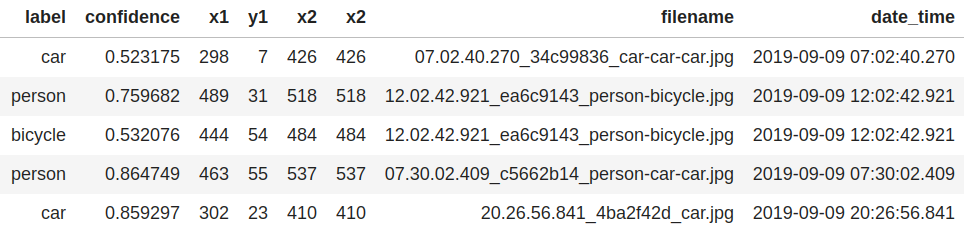

In [12]:
Image("../Resources/img/fcst-detections.png")

This dataset contains the folders and filenames of the collected images.

Raw images can be very useful for many purposes (like forensic investigations, automated alerts, or simply historical value), but they need some form of pre-processing before they can be used for Machine Learning.

Computer Vision is a vast area of Artificial Intelligence, which provides plethora of guidelines and solutions for image processing and image content analysis.

I have defined a function called `process_frame`, which allows to perform morphological operations on images using flags as function arguments. It was partially inspired by an article on the popular Computer Vision blog - PyImageSearch <cite data-cite="rosebrock:2020:anomaly">(Rosebrock, 2017)</cite>:

- convert to gray scale
- apply Median blur
- apply Thresholding
- crop ROI using polyfill

Here is an example of an original image, and below are the morphological operations applied to it:

<p style="text-align: center; margin-bottom: 5px;">Fig. 6.11. Original image</p>

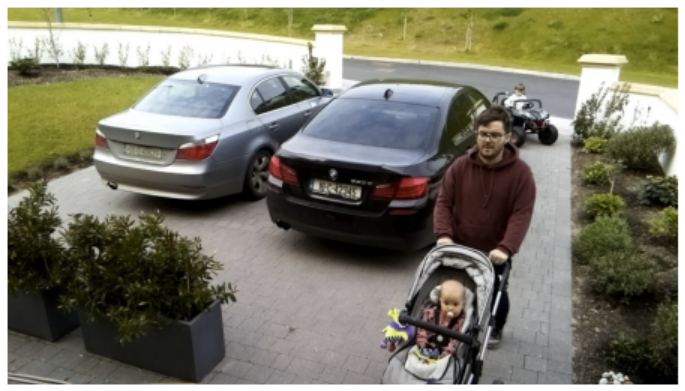

In [13]:
Image("../Resources/img/orig-image.png")

<p style="text-align: center; margin-bottom: 5px;">Fig. 6.12. Pre-processed image</p>

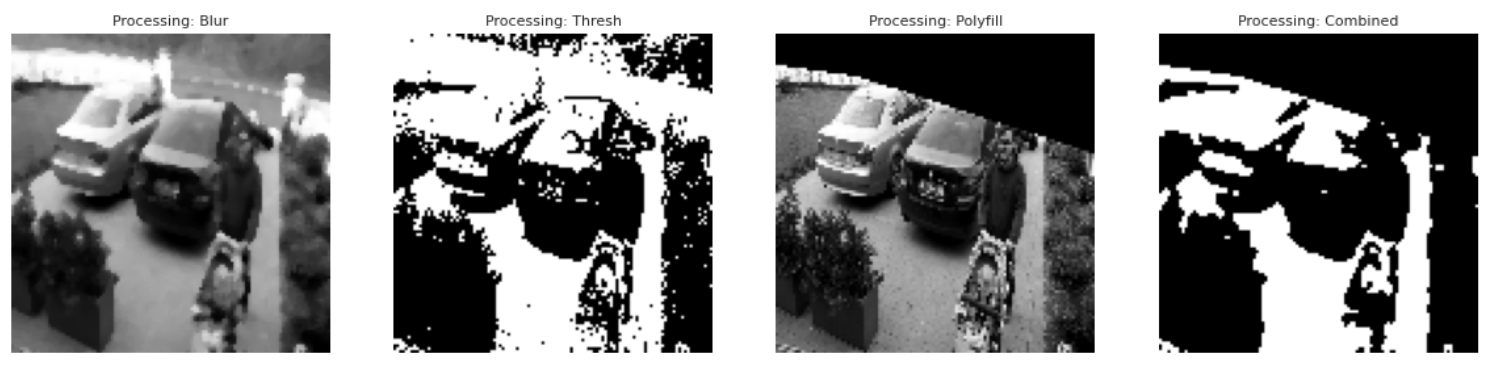

In [14]:
Image("../Resources/img/processed-image.png")

As the dataframe at the start only contains a list of all images stored on the disk, they need to be extracted into a data.

The procedure for extracting the raw image content consists of the following steps:

- pre-allocate memory in two numpy arrays: one for the image data and one for corresponding filenames
- take a sample of images (folders and filenames) from the dataframe
- iterate through the sampled dataframe and for each record:
    - open an image from the disk
    - process image using `process_frame` function by using provided pre-processing parameters
    - add image data (as a numpy array) and corresponding filename to the numpy arrays
    
Image preprocessing steps above took $1$ minute and $40$ seconds.

In terms of the resolution of the images, the higher it is, the more detail is available for the Deep Learning model, but it comes at a cost: A single gray-scale $28\times28$ pixel image generates a record with $784$ features and an image with the size $112\times112$ results in $12,544$ features respectively.

Since the original frames are captured in $Full-HD$ ($720\times1280\times3$), without resizing they would contain $2,764,800$ features per image.

Based on my experiments, increasing size to more than $608\times608$ tends to cause issues with the GPU memory and it actually degrades the performance of the model, as it learns too much noise.

Another issue with the high image quality is the speed of image pre-processing and model training: it can be a difference between minutes and hours on a single model training.

For all the above reasons I am only considering image size $56\times56$ in the rest of this Notebook. It is a good trade-off between too small and too large. I am also choosing to use $10K$ images for training, as it is the lowest number of images, which produces best final results.

The statistics from using different numbers of images and resolutions are provided in the [Summary section](#conc).

Next step is to add an extra dimension to the dataset, as Neural Network will expect the shape of (height, width and depth). The depth is needed in case if color images were used.

Normalizing the data on a $0-1$ scale helps with training stability. Since image data is a `uint8` type, it can take values only between $0$ and $255$, so dividing all values by $255.0$ is the standard normalization step for image data (data type becomes a `float32` type):

$$normalize(X)=X/255.0$$

And the last step here is to split the dataset into train and test splits. Unfortunately due to slow training times it is not advised to run cross validation splits for Deep Neural Networks. I am choosing a $0.8 / 0.2$ split with a `random_state` parameter set to a constant value for reproducibility.

The shape of the training data, which is now ready to be used in an auto encoder Neural Network is $(8000 \times 56 \times 56 \times 1)$.

### 6.2.2. Training with auto encoder

The architecture of the convolutional auto encoder below is inspired by the PyImageSearch blog entry <cite data-cite="rosebrock:2020:anomaly">(Rosebrock, 2020)</cite>. The model is built on top of [Keras](https://www.tensorflow.org/api_docs/python/tf/keras) functional API.

$$
autoEncoder=decoder(encoder(X))
$$

- Encoder:
    - Input: X_train
    - Convolutional layer: $32$ and $64$ filters, each followed by Leaky ReLU and Batch Normalization:
        - changing the size of filters or adding/removing filters have decreased the performance
        - the difference between ReLU and Leaky ReLU activations is very small, but Leaky ReLU seems to be a little more robust. I have concluded that letting some weights to be slightly negative makes a difference
    - Output: Latent (bottleneck) layer with $16$ nodes by default. Experiments with different sizes ($8$ and $32$) did not make any improvements, where $8$ nodes has decreased the performance by around $10\%$
- Decoder:
    - Input: Latent layer
    - Convolutional transpose layer: $32$ and $64$ filters, each followed by Leaky ReLU and Batch Normalization
    - Single CNN layer: this layer is used to recover the original depth
    - Activation: Sigmoid is used to make sure output values match the input range (between $0$ and $1$)
- Optimizer: Adam with learning rate $\alpha$ and decay $decay=\alpha \div nEpochs$
    - Switching optimizers to Stochastic Gradient Descent or RMS-Prop did not improve the model's performance
- Loss function: mean squared error is used as a simple and well understood error function, which will be used below to identify anomalies

I am leaving out the theory behind the Neural Network layers, as it would inflate this research significantly. It is constantly repeated across many papers and articles and would not make this section more useful. Hopefully the intuition, which is provided above is more valuable.

After many experiments with different model parameters, I have concluded that this architecture is quite optimal in its original shape:

<p style="text-align: center; margin-bottom: 5px;">Fig. 6.13. Auto Encoder summary</p>

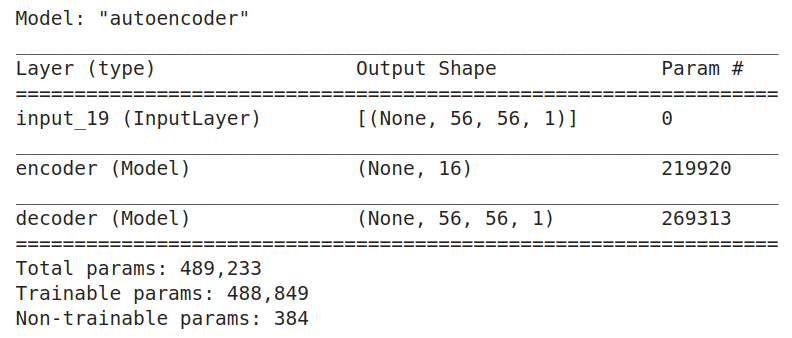

In [15]:
Image("../Resources/img/auto-encoder-summary.png")

Given the CNN-based architecture above and $56\times56$ image size, the model has almost $500K$ trainable parameters. This number goes up to $1.7M$ for $112\times112$ images.

Model converges well without any symptoms of overfitting, and only requires $10$ epochs of training with $2s$ per epoch and ends with training loss $0.0135$ and validation loss $0.0167$:

<p style="text-align: center; margin-bottom: 5px;">Fig. 6.14. Auto Encoder loss</p>

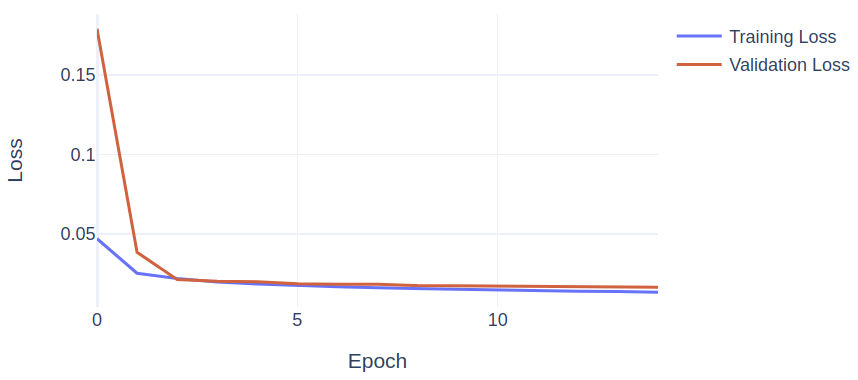

In [16]:
Image("../Resources/img/ae-loss.png")

**Notes:**

- when $25K$ images are used for training, instead of $10K$, the curves are much smoother and model converges after $30$ epochs (however it does not improve the final results, so I have discarded that model)
- it is important that the model generates some error and does not memorize the whole training set, as this kind of model would not be useful at all to detect anomalies

Below is a table, which builds an intuition around the number of epochs to converge and time it takes for each kind of sample size and image resolution:

<p style="text-align: center; margin-bottom: 5px;">Tbl. 6.1. Auto encoder - convergence statistics</p>

| Sample Size | Res.      | Sec. Per Epoch | Epochs to Converge |
|:------------|:---------:|---------------:|-------------------:|
| 10,000      | 56 x 56   | 2              | 10                 |
| 25,000      | 28 x 28   | 3              | 20                 |
| 25,000      | 56 x 56   | 6              | 30                 |
| 25,000      | 112 x 112 | 15             | 50                 |
| 50,000      | 28 x 28   | 5              | 50                 |
| 50,000      | 56 x 56   | 10             | 50                 |
| 50,000      | 112 x 112 | 28             | 50                 |

As per expectation, the more samples and the higher the resolution, the longer it takes to train each epoch and more epochs is required to converge.

### 6.2.3. Model evaluation on test-set

The test-set contains $2K$ $56\times56$ preprocessed, grayscale images, normalized to $0-1$ range.

When predictions are generated using Keras `predict` method, their values are compared against the original images and errors are calculated using *mean squared error* statistic (any suitable error measurement can be actually utilised here).

Making predictions for all $2000$ test images and calculating errors takes only $0.25$ of a second.

Then a decision needs to be made to determine a percentage of the dataset, which should be classified as anomalous. For example let this percentage be $0.99$.

Then it is possible to calculate a threshold for the error using $99$th quantile, above which points are classified as anomalies. This threshold value is $0.0651$. Below is a histogram, which shows the distribution of errors with a red dashed line, representing the calculated threshold:

<p style="text-align: center; margin-bottom: 8px;">Fig. 6.15. Auto Encoder loss</p>

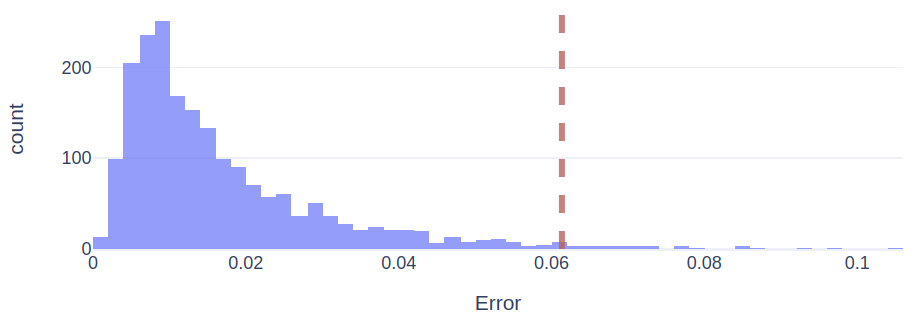

In [17]:
Image("../Resources/img/ae-error-dist.png")

To make sure the method is working, it can be very helpful to look at the images with the largest error (they would be classified as anomalous), an example is below, which shows the original image (left), with the preprocessed (middle) and reconstructed one by auto encoder (right):

<p style="text-align: center; margin-bottom: 0;">Fig. 6.16. Auto encoder - anomalous image</p>

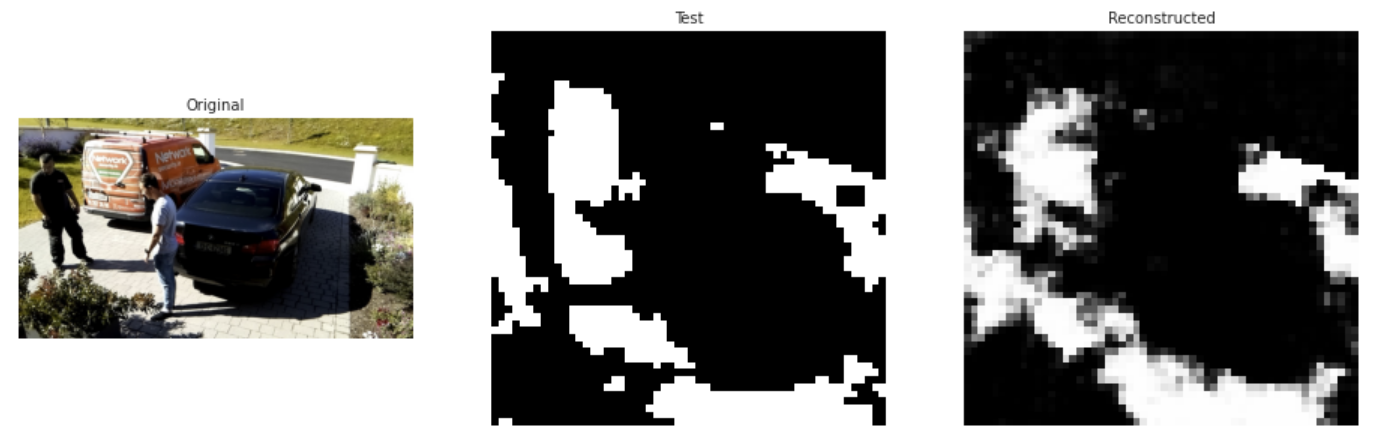

In [18]:
Image("../Resources/img/ae-high-error.png")

And looking at an image with the lowest error should display a normal frame:

<p style="text-align: center; margin-bottom: 0;">Fig. 6.17. Auto encoder - normal image</p>

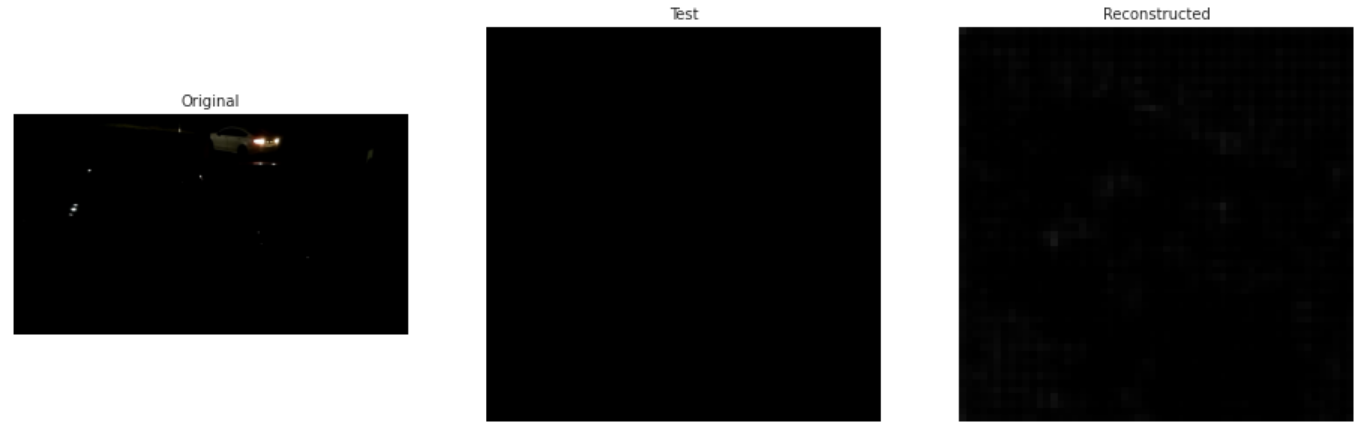

In [19]:
Image("../Resources/img/ae-normal.png")

Seems like it is working for the anomalous image (as there is a lot going on in that frame and this kind of event should be flagged as an anomaly).

But it is somewhat surprising in case of the normal image. The first $8$ normal images are very dark and contain a lot of pixels with a value of zero, so reconstructing those is much easier for the model and therefore the error will be much lower as well.

So, what can be said about the output of this procedure?

I think it has the potential, but it most likely needs some improvements in the data collection stage, and perhaps more computer vision preprocessing steps (for example one of the images with highest error was flagged due to the dry patches of otherwise wet surface, and perhaps more sensitivity is required when it is dark).

Finally the training procedure needs to be carefully crafted. Instead of training the model on the whole data, a better idea would be to train on a few rolling months. This would help if the region of interest changes over time (people change their cars or plant new trees, or even move the camera to another location).

### 6.2.4. Model evaluation on hand-labeled data

The very last step in terms of auto-encoder analysis is a test with labeled images. This is very helpful, as it allows to generate metrics to compare several various models analytically.

For this purpose I have manually annotated 30 images:

- 15 as non-anomalous
- 15 as anomalous

**Procedure:**

The process is almost the same as error calculation in the previous step (I have defined a helper function called `test_anomalies` for this task):

- load images from the disk (non-anomalous and anomalous samples reside in their respective 0 and 1 folders)
- pre-process images and reshape data
- run prediction through auto-encoder Keras model
- calculate mean squared errors
- establish if anomalies are found based on the previously calculated threshold ($0.0651$)
- show images (optionally)
- plot errors from auto-encoder (optionally)
- return anomaly boolean flags for each image

**Evaluation metrics:**

Now the labels are available and standard classification metrics to evaluate model's performance can be utilized <cite data-cite="contributor:2019:roc">(Stackabuse, 2020)</cite>:

- Accuracy

Accuracy measures a percentage of correct predictions out of all predictions:

$$Accuracy=\frac{TP+TN}{TP+TN+FP+FN}$$

where $TP$ are True Positives, $TN$ are True Negatives, $FP$ are False Positives and $FN$ are False Negatives

- Precision

Precision tends to be a good metric when the cost of False Positives is high. Out of all the predicted positive instances, how many were predicted correctly:

$$Precision=\frac{TP}{TP+FP}$$

- Recall

Contrary to Precision, Recall is a useful metric when the cost of False Negatives is high. Out of all the positive classes, how many instances were identified correctly:

$$Recall=\frac{TP}{TP+FN}$$

- F1 Score

F1 Score is a mixture of Precision and Recall in a single metric (when classifying 0's and 1's correctly are both equally important). F1 Measure is also called a harmonic mean of Precision and Recall:

$$F1=2*\frac{Precision*Recall}{Precision+Recall}$$

In the case of anomaly detection, accuracy tends to be a poor measure due to the dominance of the *Normal* observations. Precision is also not the most useful metric, as the cost of falsely classified observations as an anomalies tends to be less detrimental than not catching them at all.

As a result of the above statements, *Recall* is the most important metric to observe and optimize for, while keeping an eye on the F1 Score to not sacrifice too much on the other type of errors.

Below is the plot showing previous error distribution with the red dashed line representing the anomaly threshold, and a set of short red and green lines showing anomalous and normal predictions respectively:

<p style="text-align: center; margin-bottom: 5px;">Fig. 6.18. Auto encoder - hand crafted images classification</p>


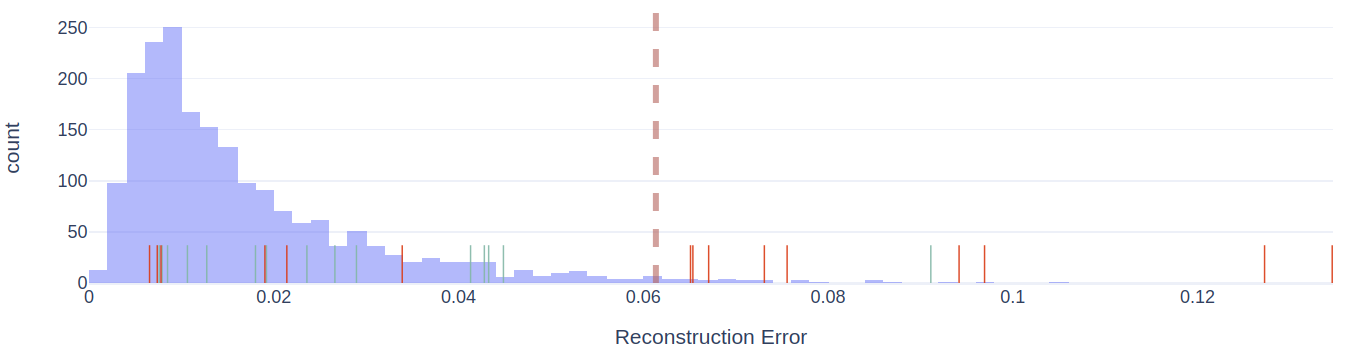

In [20]:
Image("../Resources/img/au-hand-crafted-hist.png")

The perfect score would put all green lines on the left side of the threshold (red dashed) line and all red short lines on the right hand side.

The plot shows $6$ anomalous images misclassified out of $15$.

Below are the metrics for using the current model, trained previously:

- acc: $0.77$
- prec: $0.9$
- rec: $0.6$
- f1: $0.72$

Most misclassified images can be explained by not enough variety against what is seen as a normal frame. A potentially good improvement would be to apply some computer vision to detect when it is dark, and increase error sensitivity during nightly hours. Below is an example of anomalous image, which has been classified as normal:

<p style="text-align: center; margin-bottom: 5px;">Fig. 6.19. Auto encoder - misclassification</p>

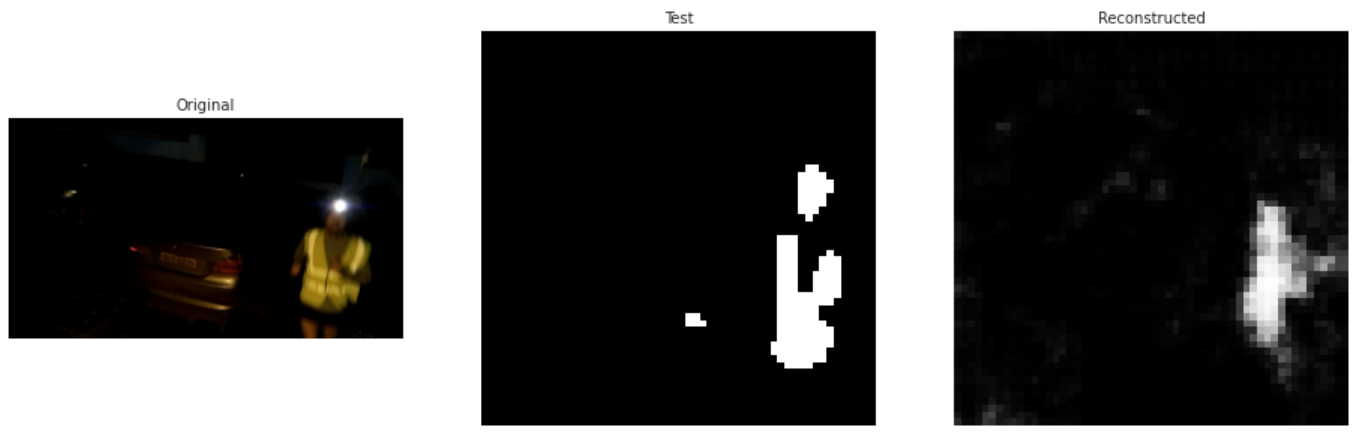

In [21]:
Image("../Resources/img/ae-misclassification.png")

### 6.2.5. Summary
<a id="conc"></a>

For the reference, below is a table with the statistics collected for all types of models trained as part of this exercise (with the model names representing the number of training samples, resolution and pre-processing parameters), sorted by highest Recall value:

<p style="text-align: center; margin-bottom: 5px;">Fig. 6.20. Auto encoder - model selection - metrics</p>

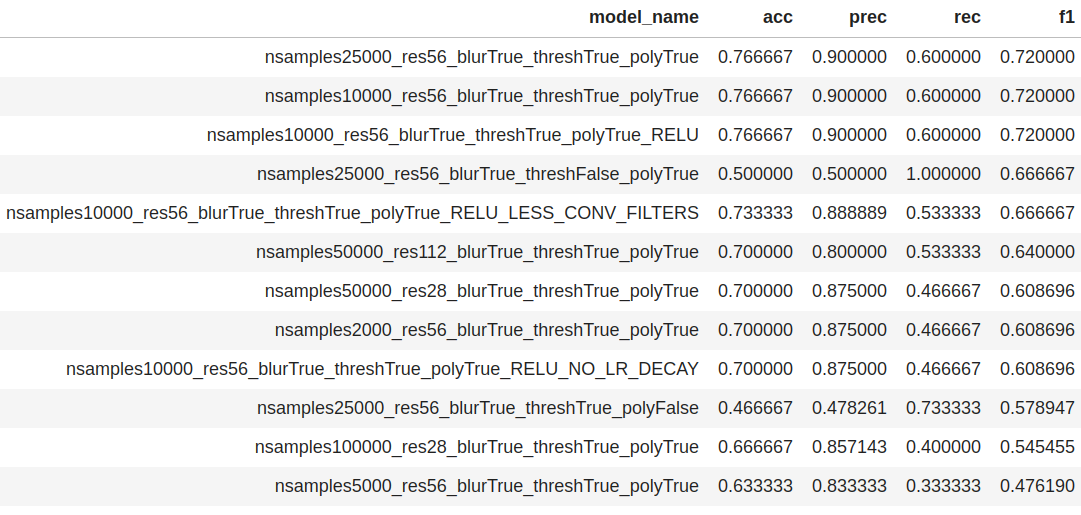

In [22]:
Image("../Resources/img/ae-all-metrics.png")

## 6.3. Conclusion

It turned that that collected data does contain some anomalous signals, which can be exploited by statistics, machine learning and computer vision.

Both methods from sections 6.1. and 6.2. are only some examples of what can be done with object detection data from anomaly detection perspective and readers are certainly encouraged to think about their use cases.

In section 6.1. it was very easy to fall into a pitfall of *IQR* method, but since it is not suitable for skewed datasets - a much more flexible approach has been developed using probabilistic programming and Poisson distribution characteristics.

Then paragraph 6.2. showed promising capabilities for real time image scoring using auto-encoders.

There are many other techniques, which I am planning to explore in the future, like using the actual forecast from chapter 5 in section 6.1., and using a Variational Auto Encoder in 6.2.

The next [chapter](./07.Conclusions.ipynb) contains the final conclusion surrounding this research as a whole and more call-outs for future opportunities and improvements.

[index](../Index.ipynb) | [prev](./05.Forecasting.ipynb) | [next](./07.Conclusions.ipynb)